In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectPercentile, f_classif

number of entries:  3549
number of unique item ID: 260
number of unique item description: 2816 

country_name
GERMANY    1279
SPAIN      2270
dtype: int64 

list of retailers:
 ['CRISTALES' 'LENTES OFTALMICAS' 'LENTE' 'LENTES ORGANICA MONOFOCAL'
 'LENTES ORGANICA PROGRESIVA' 'LENTE|ORGANICA PROGRESIVA'
 'LENTE|ORGANICA MONOFOCAL' 'PROGRESIVO' 'MONOFOCAL' 'LENTES OFTÁLMICAS'
 'UNASSIGNED' 'LENTE|ORGANICA|PROGRESIVA' 'LENTE|ORGANICA|MONOFOCAL'
 'SUPLEMENTO|SOL|.' '253' 'GLA' 'LENTES' '||PROGRESIVA'
 'LOFT/ESTD/PROG/ORGAN' 'LOFT/ESTD/MONO/ORGAN' 'VIDRES' 'LENTES/CRISTALES'
 'LENTES OFTÂŒMICAS' 'SF06' 'LENTE|ORGANICA|BIFOCAL'
 'LENTES|ORGANICA PROGRESIVA' 'LENTES|ORGANICA MONOFOCAL'
 'LENTE|MINERAL|MONOFOCAL' 'LENTES//ORGANICA MONOFOCAL'
 'LENTES//ORGANICA PROGRESIVA' 'LENTES//POLICARBONATO PROGRESIVA'
 'LENTES//MINERAL MONOFOCAL' 'LENTES//ORGANICA BIFOCAL' 'LENTE|PROGRESIVA'
 'LENTE|MONOFOCAL' '001' '722803' '722802' '722801'
 'LENTE|MINERAL|PROGRESIVA' 'LENTE|ORGANICA BIFOCAL' 'MONT'
 'L

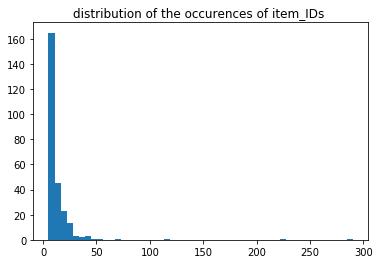

In [2]:
data = pd.read_csv('./data/train_lenses_ds_task.csv', usecols=range(4), encoding='utf8')

# check missing values that are not labeled 'UNASSIGNED', e.g. empty string
if data.isna().any().any():
    print('[warning]: na-values in data')

# simple summary
print('number of entries: ', len(data))
print('number of unique item ID:', data['item_id'].unique().shape[0])
print('number of unique item description:', data['main_text'].unique().shape[0], '\n')

print(data.groupby('country_name').size(), '\n')

print('list of retailers:\n', data['retailer_pg'].unique(),  '\n')

# distribution of item_id
plt.hist(data.groupby('item_id').size().values, bins=50)
plt.title('distribution of the occurences of item_IDs ')
plt.show()

In [3]:
def preprocess_retailer_pg(company_str):
    """
    Normalize company names into a tuple of (company, additional
    information). E.g. LENTES OFTALMICAS -> (LENTE, OFTALMICAS). If
    company does not have additional information set the latter to the
    empty string.
    """
    
    for word in ['|', '-', '.', '/', '//', '|', '||']:
        company_str = company_str.replace(word, ' ')
    company_str = ' '.join(company_str.split())
    #company_str = re.sub('\d+', ' ', company_str)

    if not 'LENTE' in company_str:
        ret = company_str, "" 
    else:
        for word in ['LENTES', 'LENTE']:
            company_str = company_str.replace(word, ' ')
        company_str = ' '.join(company_str.split())
        ret = 'LENTES', company_str

    return ret


def preprocess_main_text(text):
    """
    Normalize decimal operator in numbers and
    remove unnecessary delimiters from the text.
    """
    
    numbers = re.findall(r'(\d+[,.]*\d*)', text)
    for number in numbers:
        text = text.replace(number, number.replace(',', '.'))

    delimiters = ['(', ')', '//', '/', ';', '?', ' + ', ' - ', '&', '^', ':', '|', ',', '·']
    for delimiter in delimiters:
        text = text.replace(delimiter, ' ').strip(delimiter)

    return ' '.join(text.split())


def preprocess_data(data):
    """
    Preprocess the whole data, encode the labels
    and split into train and test data set.
    """
    data_ = data.copy()
    
    # encode item_id (use the whole data)
    label_enc = LabelEncoder()
    data_['item_id'] = label_enc.fit_transform(data_['item_id'])

    # preprocess retailer_pg
    retailer_trf = data_['retailer_pg'].apply(preprocess_retailer_pg)
    data_['retailer_pg'], data_['retailer_pg2'] = zip(*retailer_trf)
    # print('list of retailers_pg:\n', data['retailer_pg'].unique(), '\n')
    # print('list of retailers_pg2:\n', data['retailer_pg2'].unique())
    
    # preprocess main_text
    data_['main_text'] = data_['main_text'].apply(preprocess_main_text)
    # data_['main_text'].to_csv('/tmp/main_text', index=False)
    
    return data_


data_ = preprocess_data(data)
print(data_)

      item_id                                          main_text country_name  \
0         241                            ID1.60LIFESTL3IURBAN RX        SPAIN   
1         241                            ID1.60LIFESTL3IURBAN RX        SPAIN   
2         241                            ID1.60LIFESTL3IURBAN RX        SPAIN   
3         241                            ID1.60LIFESTL3IURBAN RX        SPAIN   
4         241                            ID1.60LIFESTL3IURBAN RX        SPAIN   
5         110                       ESS ILIKIA XTRA FIT ORMIX 16        SPAIN   
6         110                       ESS ILIKIA XTRA FIT ORMIX 16        SPAIN   
7         250                                   BALANSIS 1.60 RX        SPAIN   
8         250                                   BALANSIS 1.60 RX        SPAIN   
9         241  CRISTALES ID1.60LIFESTL3URBAN RX PROGRESIVOS O...        SPAIN   
10        241                            ID1.60LIFESTL3IURBAN RX        SPAIN   
11        250               

In [4]:
def extract_labels_features(data_, test_size=0.5):
    """
    Apply vectorizer on main_text and use onehot encoding
    on the other categorical features.

    data_ : preprocessed data
    """

    train, test = train_test_split(data_, test_size=test_size, stratify=data_['item_id'], random_state=42)
    
    # labels
    labels_train, labels_test = train['item_id'], test['item_id'] 
    
    # vectorizer for 'main_text'
    features1 = 'main_text'
    vectorizer = CountVectorizer(lowercase=False, token_pattern='\S+')
    features1_train = vectorizer.fit_transform(train[features1]) # keep sparse
    features1_test  = vectorizer.transform(test[features1])

    # feature selection from 'main_text'
    selector = SelectPercentile(f_classif, percentile=20)
    features1_train = selector.fit_transform(features1_train, labels_train).toarray()
    features1_test = selector.transform(features1_test).toarray()    
    
    # one-hot encoding for 'country_name', 'retailer_pg', 'retailer_pg2'
    features2 = ['country_name', 'retailer_pg', 'retailer_pg2']
    onehot_enc = OneHotEncoder(handle_unknown='ignore')
    features2_train = onehot_enc.fit_transform(train[features2]).toarray()
    features2_test = onehot_enc.transform(test[features2]).toarray()
    
    # combine features
    features_train = np.c_[features1_train, features2_train]
    features_test = np.c_[features1_test, features2_test]
    
    return features_train, features_test, labels_train, labels_test


# ignore the warning (traced back to f_classif)
features_train, features_test, labels_train, labels_test =\
    extract_labels_features(data_, test_size=0.2)

/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


In [5]:
# first trial
clf = RandomForestClassifier(random_state=42)
clf.fit(features_train, labels_train)
labels_pred = clf.predict(features_test)
print('accuracy: %.3f'%accuracy_score(labels_test, labels_pred))

accuracy: 0.889


In [6]:
# run cross validation
models = {
    'SVM': SVC(kernel='rbf', class_weight='balanced'),
    'RF' : RandomForestClassifier(n_estimators=100, criterion='gini', class_weight='balanced')
}
param_grids = {
    'SVM' : dict(C=[0.1, 1, 10], gamma=['auto', 'scale']),
    'RF'  : dict(max_depth=[None, 5, 3], max_features=[None, 'auto'])
}
clfs = {}

for name in models.keys():
    
    clf = GridSearchCV(models[name], param_grids[name], cv=4, n_jobs=4, verbose=10)
    clf.fit(features_train, labels_train)
    
    print('best estimator parameters for %s:\n'%name, clf.best_estimator_, '\n')
    clfs[name] = clf

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   32.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   48.6s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  20 out of  24 | elapsed:  1.2min remaining:   14.2s
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:  1.3min finished


best estimator parameters for SVM:
 SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   34.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   37.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   40.1s
[Parallel(n_jobs=4)]: Done  20 out of  24 | elapsed:   40.7s remaining:    8.1s
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:   41.1s finished


best estimator parameters for RF:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


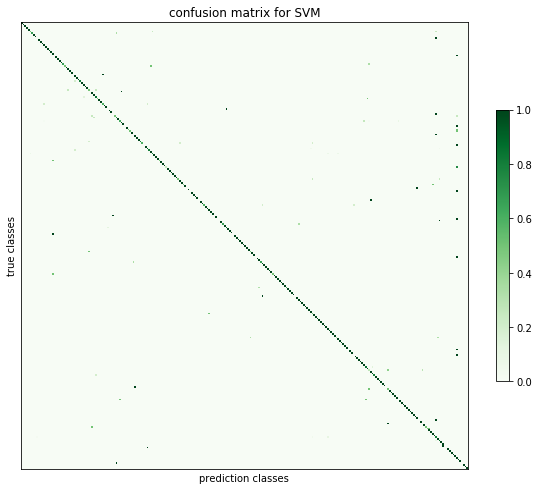

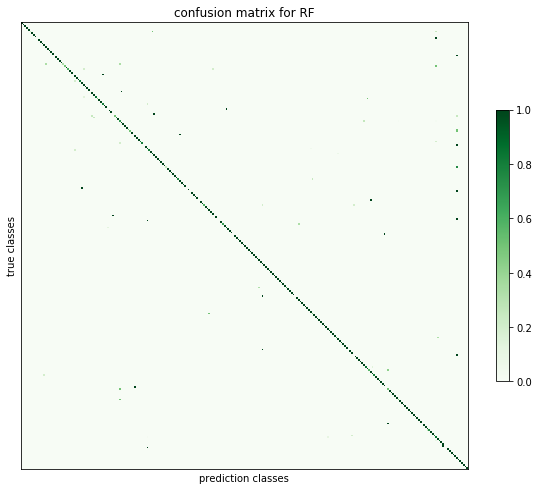

In [7]:
# dump classification report and visualise confusion matrix
cm = {}

for name  in models.keys():
    labels_pred = clfs[name].predict(features_test)
    cm[name] = confusion_matrix(labels_test, labels_pred, normalize='true')

    print(
        'classification report for %s:\n'%name,
        classification_report(labels_test, labels_pred),
        file=open('./clfreport_%s.txt'%name, 'w')
    )
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm[name], cmap='Greens')
    plt.title('confusion matrix for %s'%name, fontsize='larger')
    plt.colorbar(shrink=0.5)
    plt.xlabel('prediction classes')
    plt.xticks([])
    plt.ylabel('true classes')
    plt.yticks([])

plt.show()